MLP - Multi Layer Perceptron

# Pytorch 개발 Process

1. **데이터 준비**
    - Dataset 준비
    - Dataloader 생성

2. **입력과 출력을 연결하는 Layer(층)으로 이뤄진 네트워크(모델)을 정의**
    - **Sequential 방식**: 순서대로 쌓아올린 네트워크로 이뤄진 모델을 생성하는 방식
        - layer를 순서대로 쌓은 모델을 구현할때 간단히 모델을 정의할 수 있다.
        - layer block을 정의하는데 사용할 수 있다.
    - **Subclass 방식**: 네트워크를 정의하는 클래스를 구현.
        - 다양한 구조의 모델을 정의할 수 있다.
        - inializer에서 필요한 layer들을 생성한다.
        - forward(self, X) 메소드에 forward propagation 계산을 구현한다.
    

3. **train**
    - train 함수, test 함수 정의

4. test set 최종평가

# MNIST 이미지 분류 
- **[MNIST](https://ko.wikipedia.org/wiki/MNIST_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B2%A0%EC%9D%B4%EC%8A%A4) (Modified National Institute of Standards and Technology) database**
- 흑백 손글씨 숫자 0-9까지 10개의 범주로 구분해놓은 데이터셋
- 하나의 이미지는 28 * 28 pixel 의 크기
- 6만개의 Train 이미지와 1만개의 Test 이미지로 구성됨.

## import

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import os

import matplotlib.pyplot as plt

print(f'파이토치 버전:',torch.__version__)

파이토치 버전: 2.0.1+cpu


### device 설정

In [4]:
device = 'cuda' if torch.cuda.is_available() else "cpu"

### 변수 설정

In [5]:
BATCH_SIZE= 256  # 일괄적으로 처리할 때의 Data 의개수 , 학습/검증할 때 한번에 몇개의 데이터를 가지고 할지 개수

# 6만개 데이터 -> 학습 시킬때 -> 모델에게 Data를 줘야함 -> 60000개중에 256개를 주고 다시 학습시키고 6만개에서 남은 것을 다시 256개 집어서 넣음
# 이렇게 6만개 하나(Data set)가 학습되면 1epoch라고 한다
N_EPOCH=  20 # 전체 Train set 을 한번 학습 시키는 것 -> 1. epoch,  epoch수, 크게 잡아준다 (책을 한번 본다고 잘하는게 아니다 )

# epoch가 진행됨에따라 성능이 증가하다가 중간에 떨어진다. 그 중간 최고지점을 확인해야한다.. 그렇기에 epoch를 길게 잡아준다
LR = 0.001 # 학습률, Gradient (파라미터 업데이트할 때  지정할 학습률. gradient의 어느 정도를 파라미터 업데이트 할 때 사용할 것인지 비율.)

DATASET_SAVE_PATH = 'datasets' # 데이터 셋을 저장할 디렉터리
MODEL_SAVE_PATH='models'  # 학습된 모델을 저장할 디렉터리

os.makedirs(DATASET_SAVE_PATH,exist_ok=True)
os.makedirs(MODEL_SAVE_PATH,exist_ok=True)

## MNIST dataset Loading

### Dataset

In [6]:
# ToTensor() -> ndarray, PIL.Image 객체 --> Tensor 변환 , 정규화.(0. ~1.)

In [7]:
train_set= datasets.MNIST(root=DATASET_SAVE_PATH, # 데이터 셋을 저장할 디렉터리,
                         train = True, # trainset(True) / testset(False) 중 어떤 것 받을것인지 정하는 거
                          download=True, # root 에 데이터 셋이 없으면 다운 받을지 여부
                          transform=transforms.ToTensor(), # 데이터 전처리 하는 객체 생성
                          
                         )
test_set= datasets.MNIST(root=DATASET_SAVE_PATH, # 데이터 셋을 저장할 디렉터리,
                         train = False, # trainset(True) / testset(False) 중 어떤 것 받을것인지 정하는 거
                          download= True, # root 에 데이터 셋이 없으면 다운 받을지 여부
                          transform=transforms.ToTensor(), # 데이터 전처리 하는 객체 생성
                          
                         )

In [11]:
print(type(train_set))
print(type(test_set))
print(train_set)
print("="*50)
print(test_set)

<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>
Dataset MNIST
    Number of datapoints: 60000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: datasets
    Split: Test
    StandardTransform
Transform: ToTensor()


In [12]:
len(train_set),len(test_set) # 데이터 갯수 확인

(60000, 10000)

### DataLoader

In [10]:
train_loader = DataLoader(train_set, # Dataset
                          batch_size=BATCH_SIZE, 
                          shuffle=True, # 학습시 , 1 에폭이 끝나면 데이터를 섞어줄지 여부.(기본:False)
                         drop_last = True # 마지막 배치의 개수가 batch_size보다 적으면 버린다.
                         )
test_loader= DataLoader(test_set,batch_size=BATCH_SIZE)

# drop_last 를 주는 이유 256개를 해야하는데 90개만 남으면 마지막 배치를 학습할때 90개는 256개를 학습시킨것에서 과적합이 일어날수 있다
# 그래서 버리고 shuffle에서 다시 랜덤값으로 들어갈수 있으니 넘어가게 한다!

In [11]:
print(f"trainset의 1 에폭당 step 수: {len(train_loader)}")
print(f"testset의 1 에폭당 step 수: {len(test_loader)}")
# step = 모델(파라미터) 업데이트 단위. 
# 1 에폭당 스탭수 : 전체 train 데이터수 /batch_size
# 

trainset의 1 에폭당 step 수: 234
testset의 1 에폭당 step 수: 40


## 네트워크(모델) 정의
- Network : 전체 모델 구조

In [12]:
## nn.Module을 상속
class MNISTModel(nn.Module):
    
    def __init__(self):
        """
        모델 객체 생성시, 모델을 구현할 때 필요한 것들을 초기화.
        필요한 것: Layer들 
        
        """
        super().__init__() # 1. 부모클래스의 __init__() 을 호출해서 초기화.
        self.lr1= nn.Linear(28*28,128) # 28*28(784) 개(Input)의 입력데이터가 들어온것의 linear regression을 128개(Output) 만들어줘~
         # (WX + B) 선형회귀 계산 ->Linear(inputfeatrue 개수: 파라미터 개수, output의 개수:유닛 노드의 개수) -> Layer: 유닛의묶음
        self.lr2=nn.Linear(128,64) # 
        self.lr3= nn.Linear(64,10)
        
        
    def forward(self,X):
        """
        입력을 받아서 최종 출력할 때 까지의 계산 흐름을 구현하는 메소드.
        ===> 순전파(forward propagation)
        파라미터 X: 입력값.- batch 단위로 받는다 
        """
        X = torch.flatten(X, start_dim=1) # axis1 이후를 flatten으로 변경
        # 3차원인 이미지를 1차원으로 변환 (데이터 개수-batch,channel,height,width) ->(batch,c*h*w)
        X = self.lr1(X) # WX+b
        X= nn.ReLU()(X) # 활성화 함수(activation functio)  -> 비선형함수.
        # ReLu는  음수는 양수로 양수는 양수로 반환  -2 -> 0, 2 -> 2 로 반환
        X= self.lr2(X)
        X=nn.ReLU()(X)
        X=self.lr3(X)
        
        return X # 최종 모델의 리턴값
    


In [13]:
#정의한 모델 클래스로부터 모델 객체를 생성

model =MNISTModel()

In [14]:
# 모델의 구조를 확인 
print(model)

MNISTModel(
  (lr1): Linear(in_features=784, out_features=128, bias=True)
  (lr2): Linear(in_features=128, out_features=64, bias=True)
  (lr3): Linear(in_features=64, out_features=10, bias=True)
)


In [32]:
# 모델의 구조를 확인하는 라이브러리  -> torchinfo
# !pip install torchinfo

In [15]:
from torchinfo import summary
summary(model,(BATCH_SIZE,784)) # (모델 객체, input 데이터의 shape) (100:batch_size,784:input data)

Layer (type:depth-idx)                   Output Shape              Param #
MNISTModel                               [256, 10]                 --
├─Linear: 1-1                            [256, 128]                100,480
├─Linear: 1-2                            [256, 64]                 8,256
├─Linear: 1-3                            [256, 10]                 650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (M): 28.00
Input size (MB): 0.80
Forward/backward pass size (MB): 0.41
Params size (MB): 0.44
Estimated Total Size (MB): 1.65

In [16]:
# Total params: 109,386 # 학습한 데아터
# Trainable params: 109,386
# Non-trainable params: 0
# Total mult-adds (M): 28.00
# ==========================================================================================
# Input size (MB): 0.80
# Forward/backward pass size (MB): 0.41
# Params size (MB): 0.44
# Estimated Total Size (MB): 1.65

SyntaxError: invalid syntax (781829113.py, line 1)

## train

### 모델, loss function, optimizer 생성

In [17]:
model = model.to(device) # 실제 추론을 담당할 device로 옮긴다. -> 모델,X,y

In [18]:
# Loss를 계산하는 함수. 다중분류 -> cross entropy
loss_fn= nn.CrossEntropyLoss() # nn.functional.crossentropy
# CrossEntropyLoss() -> 모델 추정 결과->> ssoftmax 적용 ->Log => log_softamx()
                        #정답(Label로 받는다)-> one hot encoding
#     Log_softmax()적용한 추정값과 *one hot encoding 한 정답간 ---> null_loss
# softmax 적용전 모델 출력값(Logit) Labelencoding 형태의 정답을 받아서 위의 과정을 처리해 loss를 계산한다

    
# optimizer -> 최적화(경사하강법)

optimizer = torch.optim.Adam(model.parameters(),lr=LR) # 모델의 파라미터(최적화 대상) ,학습률


In [19]:
next(model.parameters()).shape

torch.Size([128, 784])

# 강사님이 한 것

In [20]:
### train => train + validation
#epcoch별 학습결과를 저장할 list
train_loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(N_EPOCH):
    ###############################################
    # train (학습)
    ###############################################
    model.train() # 모델을 학습 모드로 변경.
    train_loss = 0.0 #현재 epoch의 학습 결과 loss를 저장.
    for X_train, y_train in train_loader:
        # X, y를 device로 옮긴다.
        X_train, y_train = X_train.to(device), y_train.to(device)
        # 모델 추정
        pred = model(X_train)
        # 오차(loss) 계산
        loss = loss_fn(pred, y_train)  # 매개변수 순서: (모델추정값, 정답)
        # 모델의 파라미터 업데이트
        ## 1. 파라미터에 저장된 gradient값들 초기화
        optimizer.zero_grad() # optimizer에 설정한 parameter들 초기화(0으로 설정)
        ## 2. gradient 계산 -> 계산 결과는 parameter들의 grad 속성에 저장.
        loss.backward()
        ## 3. 파라미터 업데이트
        optimizer.step() # 경사하강법 업데이트 시켜줌 new_W= W(before)- a학습률W
        # train loss를 누적
        train_loss += loss.item() # tensor에서 값을 추출
    #step별로 누적한 loss를 step수로 나눠서 epoch의 평균 loss로 저장
    train_loss /= len(train_loader)
    ###############################################
    # validate (검증)
    ###############################################
    model.eval() #모델을 검증(평가) 모드. -> 특정 layer의 경우 학습단계와 검증(추정) 단계에서 다르게 처리하는 것들이 있다.
    # 현재 epoch의 검증 결과를 저장할 변수
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        # 검증시에는 backward를 하지 않으므로 gradient를 구할 필요가 없으므로 no_grad()
        #   context manager를 이용해 검증 코드를 작성.
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            pred_val = model(X_val) #클래스별 확률
            # loss 계산
            val_loss += loss_fn(pred_val, y_val)
            # 정확도 계산
            ## 추정한 클래스를 조회
            pred_label = pred_val.argmax(axis=-1)
            val_acc += torch.sum(pred_label == y_val).item()
        # val_loss, val_acc의 평균
        val_loss /= len(test_loader)   #step으로 나눔.
        val_acc /= len(test_loader.dataset)   #전체 데이터수
        # 현재 epoch 결과를 출력
    print(f"[{epoch:2d}/{N_EPOCH:2d}] train loss: {train_loss}, \
        val_loss: {val_loss}, val_accuracy: {val_acc}")
    # 리스트에 현재 epoch의 결과를 추가
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

[ 0/20] train loss: 0.5377081311029247,         val_loss: 0.25531765818595886, val_accuracy: 0.9263
[ 1/20] train loss: 0.22389318405562997,         val_loss: 0.18261821568012238, val_accuracy: 0.9452
[ 2/20] train loss: 0.16431456852035645,         val_loss: 0.1463836133480072, val_accuracy: 0.9552
[ 3/20] train loss: 0.13026488814343753,         val_loss: 0.12268637120723724, val_accuracy: 0.9635
[ 4/20] train loss: 0.10371722109042682,         val_loss: 0.1039360910654068, val_accuracy: 0.9666
[ 5/20] train loss: 0.08623580357585198,         val_loss: 0.09710873663425446, val_accuracy: 0.9695
[ 6/20] train loss: 0.07298102713006939,         val_loss: 0.09482552856206894, val_accuracy: 0.9685
[ 7/20] train loss: 0.06181979034907925,         val_loss: 0.0827043354511261, val_accuracy: 0.9733
[ 8/20] train loss: 0.05355505291850139,         val_loss: 0.08056402951478958, val_accuracy: 0.9739
[ 9/20] train loss: 0.04606504178741294,         val_loss: 0.08714322000741959, val_accuracy: 0

# 내가한 것

In [61]:
### train -> train + validation
# 학습 결과를 저장할 list
train_loss_list=[]
val_loss_list=[]
val_acc_list= []

for epoch in range(N_EPOCH):
    ###########################################3
    # train (학습)
    ############################################
    model.train() # 모델을 학습모드로 변경
    train_loss = 0.0 # 현재 epoch의 학습 결과 loss 를 저장
    for X_train, y_train in train_loader:
        # X,y를 device로 옮긴다.
        X_train, y_train = X_train.to(device), y_train.to(device)
        # 모델 추정ㅇ
        pred = model(X_train)
        # 오차(Loss ) 계산
        loss= loss_fn(pred,y_train) # 매개변수 순서:( 모델추정값, 정답)
        
        # 모델의 파라미터 업데이트
        ## 1. 파라미터에 저장된 gradient값들 초기화
        optimizer.zero_grad() # optimizer에 설정한 parameter들 초기화(0으로 설정)
        ## 2. gradient 계산 -> 계산 결과는 parameter들의 grad 속성에 저장
        loss.backward()
        ## 3. 파라미터 업데이트
        optimizer.step()
        
        # train loss를 누적
        train_loss += loss.item() # tensor에서 값을 추출
    
    # step 별로 누적한 loss를 step 수로 나눠서 epoch의 평균 loss로 저장
    train_loss/= len(train_loader) 
    

    
    
    ##############################################
    # validation(검증)
    ##############################################
    model.eval() # 모델을 검증(평가)모드 -> 특정 layer의 경우 학습단계와 검증(추정) 단계에서 다르게 처리하는 것들이 있다.
    # 현재 epoch의 검증 결과를 저장할 변수
    val_loss= 0.0
    val_acc= 0.0
    with torch.no_grad():
        # 검증시에는 backword를 하지 않으므로 gradient를 구할 필요가 없으므로 no_grad()
        # context manager를 이용해 검증 코드를 작성.
        for X_val, y_val in test_loader:
            X_val,y_val = X_val.to(device),y_val.to(device)
            pred_val= model(X_val)
            # loss 계산
            val_loss+=loss_fn(pred_val,y_val)
            # 정확도 계산
            ## 추정한 클래스를 조회 
            pred_label= pred_val.argmax(axis=-1)
            val_acc+=torch.sum(pred_label == y_val).item()
        # val_loss, val_acc의 평균
        val_loss /=len(test_loader) # step으로 나눔
        val_acc /=len(test_loader.dataset) # 전체 데이터 수
        # 현재 epoch 결과를 출력
        print(f"[{epoch+1:2d}/{N_EPOCH:2d}]train loss: {train_loss}, val_loss: {val_loss}, val_accucacy: {val_acc}")
        # 리스트에 현재 epoch의 결과를 저장
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
e= time.time()

[ 0/20]train loss: 0.0033436968729415157, val_loss: 0.10570957511663437, val_accucacy: 0.9757
[ 1/20]train loss: 0.005170391349151651, val_loss: 0.11237438768148422, val_accucacy: 0.9747
[ 2/20]train loss: 0.006080255478972252, val_loss: 0.12519624829292297, val_accucacy: 0.9729
[ 3/20]train loss: 0.007295640994314144, val_loss: 0.10956879705190659, val_accucacy: 0.9759
[ 4/20]train loss: 0.006001472059003216, val_loss: 0.12667299807071686, val_accucacy: 0.9753
[ 5/20]train loss: 0.0055124719767147634, val_loss: 0.10808777809143066, val_accucacy: 0.9784
[ 6/20]train loss: 0.002486219673796478, val_loss: 0.1085365042090416, val_accucacy: 0.9775
[ 7/20]train loss: 0.0006993488957882522, val_loss: 0.11109121888875961, val_accucacy: 0.9781
[ 8/20]train loss: 0.0003997752089375392, val_loss: 0.10867974907159805, val_accucacy: 0.9782
[ 9/20]train loss: 0.00031243225197652056, val_loss: 0.11114845424890518, val_accucacy: 0.9785
[10/20]train loss: 0.0002712841814772741, val_loss: 0.11326296627

In [51]:
# Label : 0 , 1 ,2
정답= torch.tensor([1,1,0]) 
추정= torch.tensor([[0.1,0.1,0.8],
                  [0.2,0.7,0.1],
                  [1.0,0,0]
                 ])

In [52]:
추정_label = 추정.argmax(axis=-1)
추정_label

tensor([2, 1, 0])

In [55]:
torch.sum(추정_label == 정답).item()

2

In [47]:
# dat`aloader -> iterable
v= next(iter(test_loader))

In [48]:
len(v)

2

In [49]:
v[0].shape , v[1].shape  # X,y로 반환 -> [X,y] X와 y를 리스트로 묶어서 반환 -> batch 단위로 제공 

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

### 학습 및 검증

### 학습 로그 시각화

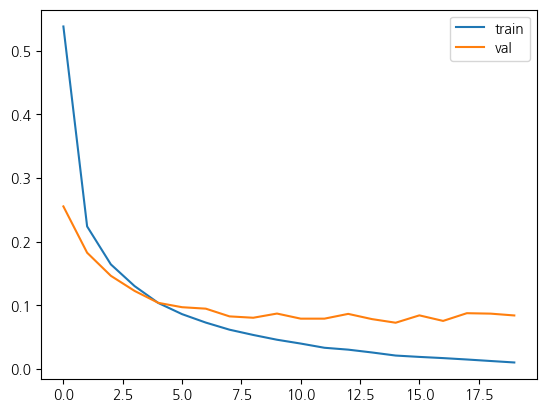

In [21]:
plt.plot(range(N_EPOCH),train_loss_list,label="train")
plt.plot(range(N_EPOCH),val_loss_list,label='val')
plt.legend()
plt.show()

In [ ]:
plt.plot(range(N_EPOCH), val_acc_list)
plt.show()

## 학습된 모델 저장 및 불러오기

In [22]:
save_path =os.path.join(MODEL_SAVE_PATH,"MNIST","mnist_mlp.pth")
os.makedirs(os.path.join(MODEL_SAVE_PATH,"MNIST"),exist_ok=True)

In [23]:
torch.save(model,save_path)

In [24]:
# 불러오기 
load_model =torch.load(save_path)

In [25]:
load_model

MNISTModel(
  (lr1): Linear(in_features=784, out_features=128, bias=True)
  (lr2): Linear(in_features=128, out_features=64, bias=True)
  (lr3): Linear(in_features=64, out_features=10, bias=True)
)

In [26]:
summary(load_model,(256, 784))

Layer (type:depth-idx)                   Output Shape              Param #
MNISTModel                               [256, 10]                 --
├─Linear: 1-1                            [256, 128]                100,480
├─Linear: 1-2                            [256, 64]                 8,256
├─Linear: 1-3                            [256, 10]                 650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (M): 28.00
Input size (MB): 0.80
Forward/backward pass size (MB): 0.41
Params size (MB): 0.44
Estimated Total Size (MB): 1.65

## 모델 평가

In [30]:
load_model= load_model.to(device) 
load_model.eval() #모드 전환
test_loss, test_acc= 0.0,0.0
with torch.no_grad():
    for X,y in test_loader:
        X,y= X.to(device), y.to(device)
        # 추정
        pred_proba= load_model(X)
        # 평가 - Loss, accuracy
        test_loss+= loss_fn(pred_proba,y)
        pred_label = pred_proba.argmax(dim=-1)
        test_acc+= torch.sum(pred_label ==y).item()
    # 평균
    test_loss /= len(test_loader) # step 수
    test_acc /= len(test_loader.dataset) # 데이터 수
print(f'test loss:{test_loss},test accuracy{test_acc}')

test loss:0.08415911346673965,test accuracy0.978


## 새로운 데이터 추론

In [32]:
from glob import glob

file_list = glob('test_img/num/*.png')
file_list

['test_img/num\\eight.png',
 'test_img/num\\eight2.png',
 'test_img/num\\five.png',
 'test_img/num\\four.png',
 'test_img/num\\one.png',
 'test_img/num\\seven.png',
 'test_img/num\\seven2.png',
 'test_img/num\\three.png',
 'test_img/num\\three2.png',
 'test_img/num\\two.png']

In [34]:
import cv2

In [37]:
file_cnt = len(file_list) # test할 이미지 개수.
input_tensor = torch.zeros((file_cnt,28,28)) # 입력 데이터(이미지들)을 저장할 tensor
# input_tensor.shape
for i in range(file_cnt):
    test_img = cv2.imread(file_list[i],cv2.IMREAD_GRAYSCALE)
    test_img = cv2.resize(test_img,(28,28))
    input_tensor[i]= transforms.ToTensor()(test_img) # train set 에 적영된 전처리를 적용, 개별 데이터로 처리
    
input_tensor.shape, input_tensor.min(), input_tensor.max()

(torch.Size([10, 28, 28]), tensor(0.), tensor(1.))

In [38]:
# 추론 
load_model.to(device)
load_model.eval()
input_tensor = input_tensor.to(device)

pred_proba = load_model(input_tensor)
# 확률
pred_proba.sum(dim=-1)
# 정답 확률 
proba= pred_proba.max(dim =-1).values
label=pred_proba.argmax(dim=-1)

In [39]:
# 1번의 추정정답
proba[0],label[0]

(tensor([ 4.8875, 11.3743,  6.4175,  6.4561,  2.2150,  5.6164, 14.2989,  5.5763,
          8.4725, 14.9134], grad_fn=<MaxBackward0>),
 tensor(2))

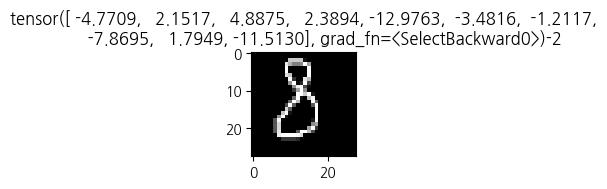

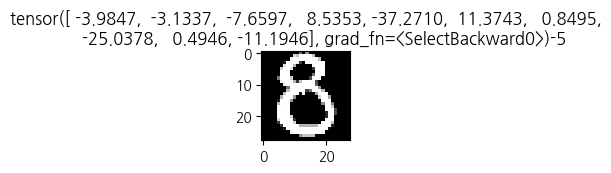

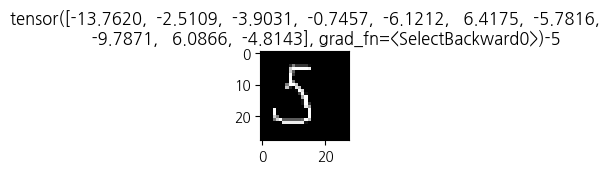

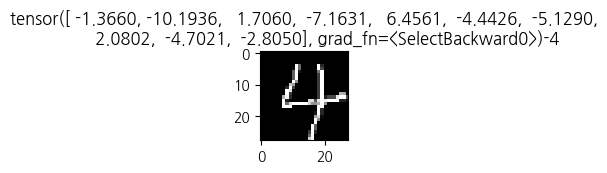

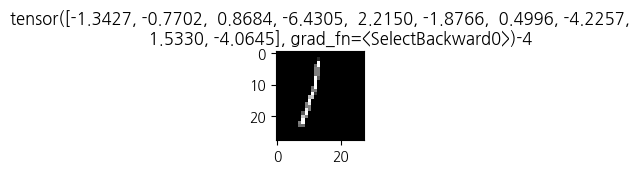

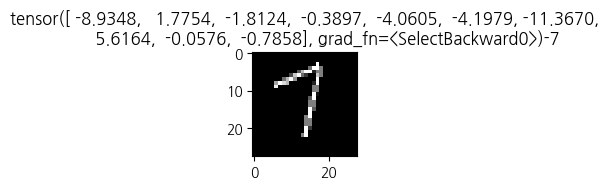

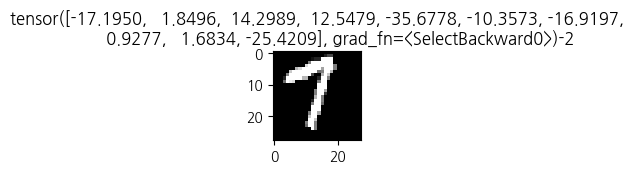

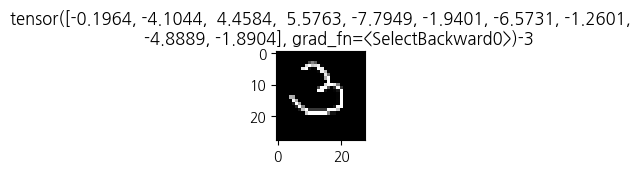

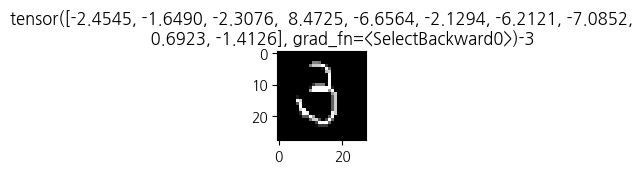

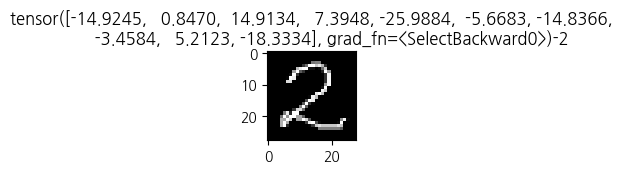

In [44]:
plt.figure(figsize=(15,7))
for i in range(file_cnt):
    plt.subplot(2,5,i+1)
    plt.imshow(input_tensor[i].to('cpu'),cmap='gray')
    plt.title(f'{pred_proba[i]}-{label[i]}')
    plt.tight_layout()
    plt.show()